# Calculando Probabilidad de ```Default``` usando ```XGBoost```
XGBoost consiste en construir en Ensamble de Arboles de Decision, es decir construir multiples arboles de decision que generaran diferentes probabilidades de Default, la combinación de estas predicciones es tomada como la prediccion final del modelo. Imainemos que tenemos dos arboles de decision que para el mismo conjunto de datos predicen que algunos clientes van a dejar de pagar sus prestamos cuando en realidad son buenos clientes, XGBoost combina las probabilidades de ambos arboles y genera una prediccion más refinada:

<img src="images/combined-weak-models.png" class="center" alt="XGBoost Example" />


In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, \
                            classification_report, \
                            precision_recall_fscore_support, \
                            roc_auc_score, \
                            confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
cr_loan_clean = pd.read_csv("data/cr_loan_nout_nmiss.csv")

In [2]:
cr_loan_clean.shape

(29459, 12)

In [3]:
cr_loan_clean.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2,VENTURE,A,2500,7.14,1,0.25,N,2


In [4]:
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

cred_str_onehot = pd.get_dummies(cred_str)
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

In [5]:
# Separacion de los features y la variable a predecir
columns = list(cr_loan_prep.columns)
X_columns = [column for column in columns if column != 'loan_status']
X = cr_loan_prep[X_columns]
y = cr_loan_prep[['loan_status']]

# Creacion del dataset de entrenamiento y de testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

Entrenamiento del modelo xgboost

In [6]:
# Entrenamiento del modelo
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

In [7]:
# Obtencion de las probabilidades
gbt_preds = clf_gbt.predict_proba(X_test)
gbt_preds

array([[0.05956489, 0.9404351 ],
       [0.07798618, 0.9220138 ],
       [0.9782927 , 0.02170731],
       ...,
       [0.73190296, 0.26809704],
       [0.7961383 , 0.20386168],
       [0.90489477, 0.09510522]], dtype=float32)

In [8]:
preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
preds_df

,prob_default
0,0.940435
1,0.922014
2,0.021707
3,0.026483
4,0.064803


In [9]:
true_df = y_test.head()
true_df

,loan_status
28606,1
22585,1
13888,0
3145,0
14882,1


In [10]:
# Concatenado de los valores reales y de las probabilidades predichas
pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)

,loan_status,prob_default
0,1,0.940435
1,1,0.922014
2,0,0.021707
3,0,0.026483
4,1,0.064803


In [11]:
portfolio = pd.DataFrame(gbt_preds[:,1], columns=['gbt_prob_default'])
portfolio = pd.concat([portfolio['gbt_prob_default'], X_test['loan_amnt'].reset_index(drop = True)], axis = 1)

In [12]:
portfolio.head()

,gbt_prob_default,loan_amnt
0,0.940435,15000
1,0.922014,11200
2,0.021707,15000
3,0.026483,10800
4,0.064803,3000


In [13]:
# En lugar de probabilidades, realizar predicciones
gbt_preds = clf_gbt.predict(X_test)

# Reporte de las predicciones
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      0.99      0.95      9198
     Default       0.93      0.69      0.80      2586

    accuracy                           0.92     11784
   macro avg       0.93      0.84      0.87     11784
weighted avg       0.92      0.92      0.92     11784



## f1-score

```F1-score``` combina precision y recall en una misma metrica, permitiendo medir ambas al mismo tiempo. Esto permite que mantengamos ```recall``` para los prestamos no pagados. La formula de ```f1-score``` es la siguiente:

<img src="images/f1-score.png" class="center" alt="f1-score" />

Probemos crear un modelo con menos columnas

In [14]:
new_x = cr_loan_prep[['person_income','loan_int_rate',
                      'loan_percent_income','loan_amnt',
                      'person_home_ownership_MORTGAGE','loan_grade_F']]

y = cr_loan_prep[['loan_status']]

# Creacion del dataset de entrenamiento y de testing
X_train, X_test, y_train, y_test = train_test_split(new_x, y, test_size=.4, random_state=123)

In [15]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'loan_percent_income': 121, 'loan_int_rate': 183, 'person_income': 278, 'person_home_ownership_MORTGAGE': 39, 'loan_amnt': 47, 'loan_grade_F': 6}


Visualicemos la importancia de las columnas utilizadas a la hora de crear el modelo

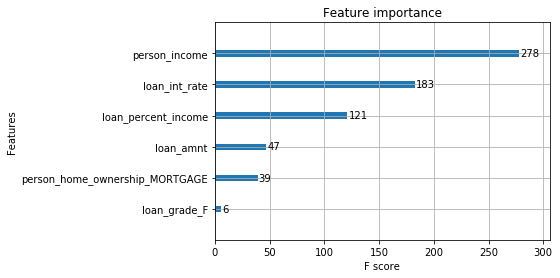

In [16]:
xgb.plot_importance(clf_gbt, importance_type='weight')
plt.show()

In [17]:
gbt_preds = clf_gbt.predict(X_test)
target_names = ['Non Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non Default       0.90      0.95      0.92      9198
     Default       0.79      0.61      0.69      2586

    accuracy                           0.88     11784
   macro avg       0.84      0.78      0.81     11784
weighted avg       0.87      0.88      0.87     11784



## Usando ```cross-validation```
Como sabemos que tan bueno será el rendimiento de las columnas que elegimos a lo largo del tiempo? 

Para esto empezaremos a usar ```cross-validation``` para testear nuestros modelos y ver como se comportaran luego de ser implementados.

```Cross-validation``` es una manera de entrenar y testear nuestro modelo multiples veces sobre los mismos datos

Con ```XGBoost``` debemos utilizar inicializar un objeto especial llamado ```DMatrix```, que es una manera de almacenar los datos de forma optimizada para que pueda ser utilizado por XGBoost.

Tambien se utilizará ```early-stopping``` que hace que el modelo deje de entrenarse luego de que el performance del modelo no haya mejorado después de una serie de pasos.

Cross-validation hace lo siguiente:
- divide el dataset en secciones llamados ```folds```
- Un grupo de los ```folds``` se utilizan para entrenar el modelo y los ```folds``` restantes se utilizan como una especie de mini ```test set``` también conocido como ```validation set```

<img src="images/cross-validation.png" class="center" alt="cross-validation" >

En el caso presentado en la imagen:
1. Se crean 5 ```folds```
2. El modelo se entrena con 4 de los ```folds``` y se testea contra el ```fold``` restante
3. El paso 2 se repite por 5 ```splits```, permitiendo que se entrenen modelos con todos los ```folds``` y cada ```fold``` sea utilizado para ```testing``` por lo menos una vez. 
4. Una vez hecho esto, los parametros son promediados luego de cada sesion de entrenamiento y luego 
5. El modelo es testeado contra el conjunto de prueba original

In [21]:
# Separacion de los features y la variable a predecir
columns = list(cr_loan_prep.columns)
X_columns = [column for column in columns if column != 'loan_status']
X = cr_loan_prep[X_columns]
y = cr_loan_prep[['loan_status']]

# Creacion del dataset de entrenamiento y de testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [23]:
params = {'eval_metric': 'auc', 
          'objective': 'binary:logistic', 
          'seed': 123}

# Valores para el numero de folds y la cantidad de iteraciones
n_folds = 5
early_stopping = 10

# DTrain matrix para XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Creacion del DataFrame de cross-validations
cv_df = xgb.cv(params, DTrain, 
               num_boost_round = 5, 
               nfold=n_folds, early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.898182       0.001318       0.892519      0.004650
1        0.909256       0.002052       0.902780      0.005053
2        0.913621       0.002205       0.906834      0.004423
3        0.918600       0.001092       0.910779      0.005221
4        0.922251       0.001818       0.914193      0.004422


## Probando con otros hiperparametros

In [31]:
# Creamos el modelo de gradient boosting trees usando 
# un learning rate de 0.1 y una profundidad maxima de 7 para 
# cada arbol del modelo
gbt = xgb.XGBClassifier(learning_rate = .1, max_depth = 7)

# Calculamos los scores de cross-validation para 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Imprimimos los scores
print(cv_scores)

# Imprimimos el accuracy promedio y la desviacion estandar
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

[0.94095023 0.93369541 0.93186962 0.92462653]
Average accuracy: 0.93 (+/- 0.01)
